In [10]:
HOST="david-vm-ubuntu"
!mkdir -p results
!mv results/result results/result_`(date +%s)`
!ssh {HOST} 'cd projects; echo "a" | sudo -S ./save_slab_orders.sh'
!scp -r -q {HOST}:projects/result results
!ssh {HOST} 'ls -l projects/result | cut -d ">" -f 2' > results/result/job

[sudo] password for vm: 

In [14]:
import os

FOLDER = 'results/result'
FILE = FOLDER + '/slabinfo'
IMAGE_FOLDER = 'images'

os.makedirs(IMAGE_FOLDER, exist_ok=True)


with open(FOLDER + '/job') as f:
    job_name = f.read().strip()

with open(FILE) as f:
    c = f.read().splitlines()

data = []
current = None

SKIP_LINES = ['# name', 'slabinfo']

headers = [
    'time',
    'name',
    'active_objs',
    'num_objs',
    'objsize',
    'objperslab',
    'pagesperslab',
    'tunables',
    'limit',
    'batchcount',
    'sharedfactor',
    'slabdata',
    'active_slabs',
    'num_slabs',
    'sharedavail',
]

with open(FOLDER + '/orders') as f:
    orders = {x.split()[0]: int(x.split()[1]) for x in f.readlines()}

def convert_num(x):
    try:
        return int(x)
    except:
        return x

for line in c:
    if line.startswith('time:'):
        current = int(line.split()[-1])
        continue
    if line.startswith('# name'):
        continue
    if line.startswith('slabinfo'):
        continue
    
    l = [current] + [convert_num(x.strip()) for x in line.split() if x is not ':']
    assert len(l) == len(headers)
    data.append(l)

Duration: 3.13 minutes


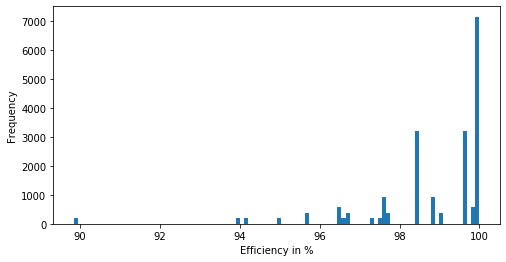

In [15]:
%matplotlib inline
import pandas as pd
import matplotlib.pyplot as plt

df = pd.DataFrame(data, columns=headers)

#df = df[df.name == 'dentry']

df['order'] = df.name.apply(lambda x: orders.get(x, 0))
df['page_size'] = 4096

df['active_vs_num'] = df.active_objs / df.num_objs

df['ef'] = df.num_objs * df.objsize * 100 / (df.num_slabs * (df.page_size * 2 ** df.order))

#df.plot(x='time', y='ef', figsize=(10, 4))
ax = df.ef.plot(kind='hist', bins=100, figsize=(8, 4))

#ax.set_title(f'SLAB efficiency\nJob: {job_name}')
ax.set_xlabel('Efficiency in %')

def sanitize_name(x):
    return x.replace('/', '___')

plt.savefig(f'{IMAGE_FOLDER}/{sanitize_name(job_name)}.png')

duration_in_seconds = max(df.time.values) - min(df.time.values)
print(f'Duration: {duration_in_seconds / 60:.2f} minutes')

In [13]:
job_name


'/lkp/result/fsmark/1HDD-9B-ext4-1x-16d-256fpd-32t-fsyncBeforeClose-400M/david-vm-ubuntu/ubuntu/x86_64-rhel-7.6/gcc-7/5.0.0-31-generic/2'